# Graphs

Copyright Luca de Alfaro, 2019-20. 
License: [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/4.0/).


Prepared on: Tue Feb 23 12:08:19 2021

This is a book chapter; it is not a homework assignment.  
Do not submit it as a solution to a homework assignment; you would receive no credit.


A (directed) graph $G = (V, E)$ consists of a set of vertices (or nodes) $V$, and a set of edges $E \subseteq V \times V$. 

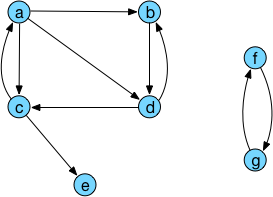

An example of a graph with $V = \{a, b, c, d, e, f, g\}$ and $E = \{(a, b), (a, c), (a,d), (b,d), (c,a), (c, e), (d, b), (d, c), (f, g), (g, f)\}$.

How should we represent a graph?  A general principle of software development -- really, of life -- is: failing special reasons, always go for the simplest solution. 
So our first attempt consists in storing a graph exactly according to its definition: as a set of vertices and a set of edges.

In [2]:
class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])


In [3]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})


Great, but, how do we display graphs?  And what can we do with them?  

Let's first of all add a method .show() that will enable us to look at a graph; this uses the library [networkx](https://networkx.github.io/).

In [4]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)


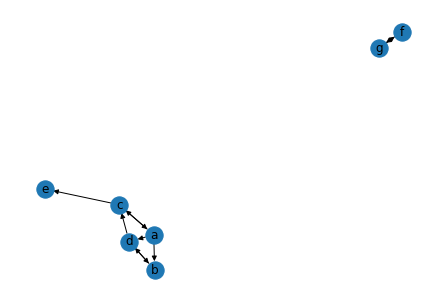

In [5]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()


Ok, this is not nearly as pretty as what we generated by hand, but it will have to do. 

## One-Step Reachability and Graph Representations

What are conceivable operations on graphs?  There are some basic ones, such as adding a vertex and adding an edge.  These are easily taken care of.

In [6]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)

    def add_edge(self, e):
        self.edges.add(e)


Further, a graph represents a set of connections between vertices, so a very elementary question to ask is the following: if we are at vertex $v$, can we get to another vertex $u$ by following one or more edges? 
 
As a first step towards the solution, we want to compute the set of vertices reachable from $v$ in one step, by following one edge; we call these vertices the _successors_ of $v$. 

Writing a function g.successors(u) that returns the set of successors of $u$ is simple enough.  Note that the code directly mimicks the mathematical definition: 

$$
\mathit{Successors}(u) = \{v \in V \mid (u, v) \in E\} \; .
$$

In [7]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)

    def add_edge(self, e):
        self.edges.add(e)

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return {v for v in self.vertices if (u, v) in self.edges}


In [8]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.successors('a')


{'b', 'c', 'd'}

But there's a rub.  The method successors, as written, requires us to loop over the whole set of vertices.  Because self.edges is a set, represented as a hash table, once we have a pair (u, v), checking 

    (v, u) in self.edges
    
is efficient.  But typically, graphs have a locality structure, so that each node is connected only to a small subset of the total vertices; having to loop over all vertices to find the successors of a vertex is a great waste. 
It is as if I asked you to what places you can get from San Francisco with a direct flight, and to answer, you started to rattle off all of the world's cities, from Aachen, Aalborg, Aarhus, ..., all the way to Zürich, Zuwarah, Zwolle, and for each city you checked if there's a flight from San Francisco to that city!  Clearly not the best method.

Given that our main use for graphs is to answer reachability-type questions, a better idea is to store the edges via a dictionary that associates with each vertex the set of successors of the vertex.  The vertices will simply be the keys of the dictionary.


In [9]:
import networkx as nx # Library for displaying graphs.
from collections import defaultdict

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        self.s = {u: set() for u in vertices or []}
        for u, v in (edges or []):
            self.add_edge((u, v))

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.s.keys())
        g.add_edges_from([(u, v) for u in self.s for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        if v not in self.s:
            self.s[v] = set()

    def add_edge(self, e):
        u, v = e
        self.add_vertex(u)
        self.add_vertex(v)
        self.s[u].add(v)

    @property
    def vertices(self):
        return set(self.s.keys())

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return self.s[u]


{'d', 'b', 'c'}


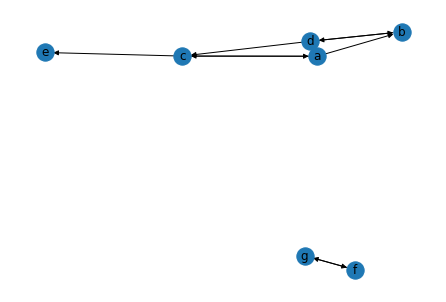

In [10]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()
print(g.successors('a'))


## Graph Reachability

We now come to one of the fundamental graph algorithms, in fact, perhaps _the_ most fundamental algorithm for graphs: computing the set of vertices reachable from a given starting vertex.  Exploring what is reachable from a graph vertex is a truly basic task, and variations on the algorithm can be used to answer related questions, such as whether a vertex is reachable from a given starting vertex. 

The algorithm keeps two sets of vertices: 

* The set of _open_ vertices: these are the vertices that are known to be reachable, and whose successors have not yet been explored. 
* The set of _closed_ vertices: these are the vertices that are known to be reachable, and whose successors we have already explored. 

Intially, the set of open vertices contains only the starting vertex, and the set of closed vertices is empty, as we have completed no exploration. 
Repeatedly, we pick an open vertex, we move it to the closed set, and we put all its successor vertices -- except those that are closed already -- in the open set.   The algorithm continues until there are no more open vertices; at that point, the set of reachable vertices is equal to the closed vertices.  

If there is _one_ graph algorithm that you must learn by heart, and that you should be able to write even when you hang upside down from monkeybars, this is it.

Let us write the algorithm as a function first. 


In [11]:
def reachable(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    vopen = {v}
    vclosed = set()
    while len(vopen) > 0:
        u = vopen.pop()
        vclosed.add(u)
        vopen.update(g.successors(u) - vclosed)
    return vclosed


In [12]:
print(reachable(g, 'a'))
print(reachable(g, 'g'))


{'a', 'c', 'e', 'b', 'd'}
{'g', 'f'}


To visualize the algorithm, let us write a version where at each iteration, open vertices are drawn in red and closed ones in green

In [13]:
import matplotlib.pyplot as plt
def color_draw(g, vopen, vclosed):
    gg = nx.DiGraph()
    gg.add_nodes_from(g.vertices)
    gg.add_edges_from([(u, v) for u in g.vertices for v in g.successors(u)])
    node_colors = ''.join([('r' if v in vopen else 'g' if v in vclosed else 'b')
                           for v in g.vertices])
    nx.draw(gg, with_labels=True, node_color=node_colors)
    plt.show()

def reachable(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    vopen = {v}
    vclosed = set()
    color_draw(g, vopen, vclosed)
    while len(vopen) > 0:
        u = vopen.pop()
        vclosed.add(u)
        vopen.update(g.successors(u) - vclosed)
        color_draw(g, vopen, vclosed)
    return vclosed


/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:478: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  label=label,


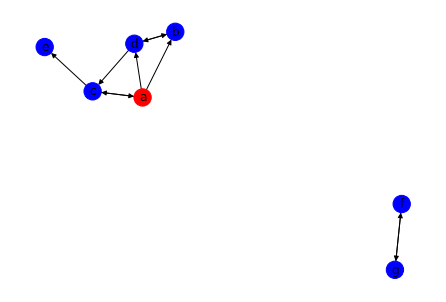

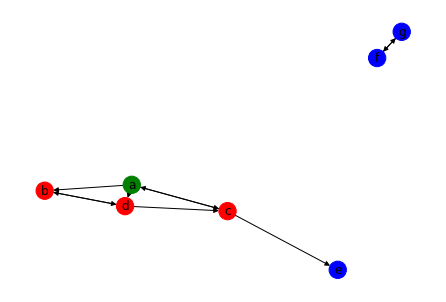

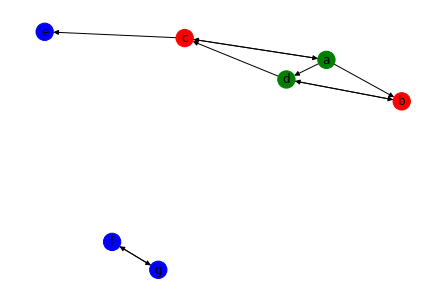

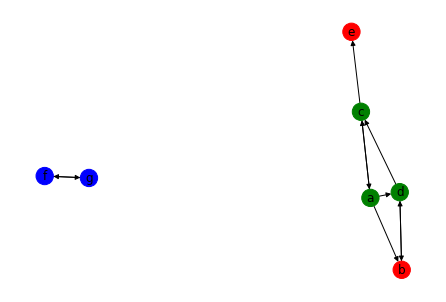

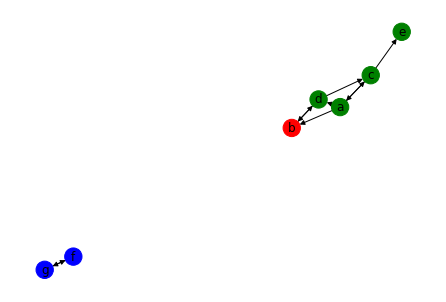

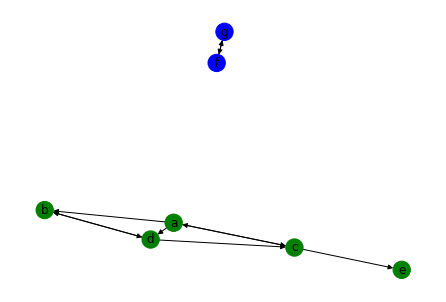

{'a', 'b', 'c', 'd', 'e'}

In [14]:
reachable(g, 'a')


## Breadth-First and Depth-First Search

### Breadth First

In **breadth-first** search, we explore in concentric circles emanating from the starting point: first all vertices at distance 1, then all vertices at distance 2, and so on.  In general, we explore all vertices at distance $\leq n$ before we explore vertices at distances $>n$. 

To implement breadth-first search, we store the open vertices `vopen` as a list rather than a set.  We then explore vertices in the order they have been added to `vopen`: this ensures that vertices closer to the search origin are explored earlier than farther-away vertices.

The difference in code between reachability search, and its specialized breadth-first version, is minimal. 


In [15]:
def breath_first(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    # vopen is a FIFO: first in, first out. Like a normal queue.
    # we add elements from the end, and pop them from the beginning.
    vopen = [v]
    vclosed = set()
    color_draw(g, vopen, vclosed)
    while len(vopen) > 0:
        u = vopen.pop(0) # Pop from the beginning
        vclosed.add(u)
        # vopen.update(g.successors(u) - vclosed)
        for w in g.successors(u) - vclosed:
            if w not in vopen:
                vopen.append(w) # Add to the end
        color_draw(g, vopen, vclosed)
    return vclosed


In [16]:
gg = Graph(vertices={},
           edges={('a', 'b'), ('b', 'c'), ('c', 'd'),
                  ('a', 'u'), ('u', 'v'), ('v', 'w'), ('u', 'z')})


/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:478: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  label=label,


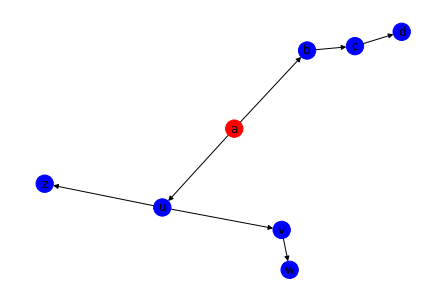

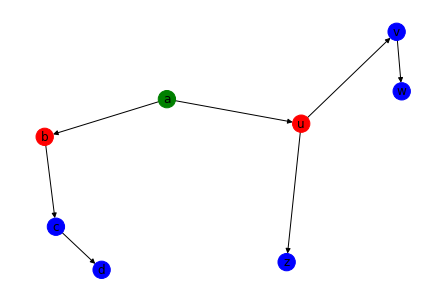

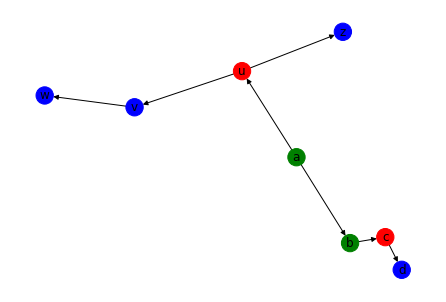

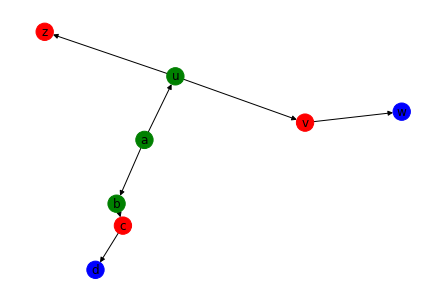

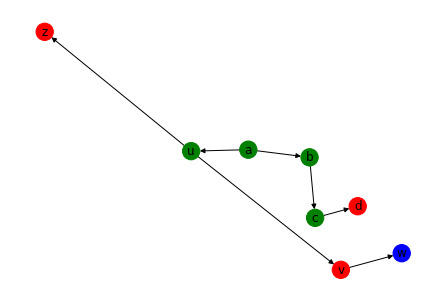

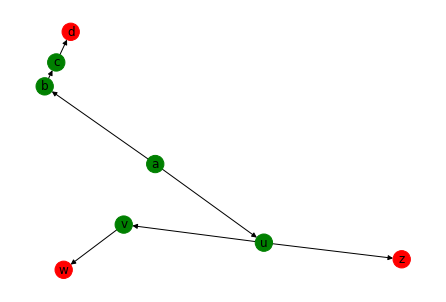

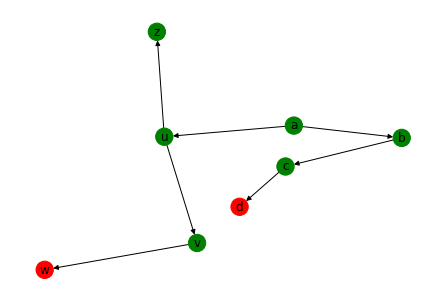

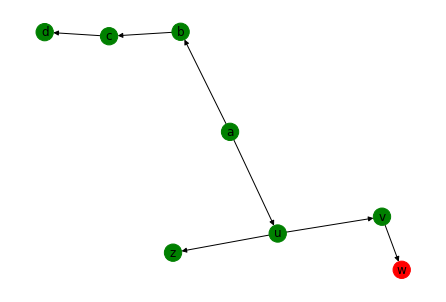

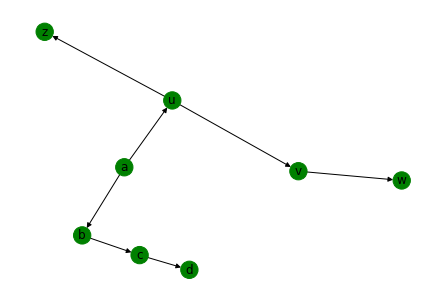

{'a', 'b', 'c', 'd', 'u', 'v', 'w', 'z'}

In [17]:
breath_first(gg, 'a')


We see that we explore $b$ and $u$ before any of their successors are explored, and similarly, we explore $z$, $v$, and $c$ before $d$ or $w$. 

### Depth-First Search

In **depth-first** search, we follow a path as long as possible, and only when we come to an end do we explore other nodes.  In depth-first search, the most recent visited vertex, the one added last to the list of open vertices, is the one that will be explored first. 

The difference in code from breadth-first search is minimal.  In breadth-first search, the vertex to be explored next is the _oldest_ among the open ones: 

        u = vopen.pop(0)

In depth-first search, it will be the _newest_ among the open ones:

        u = vopen.pop()

That's the whole difference.

In [18]:
def depth_first(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    # vopen is a stack / LIFO: last in, first out. Like a stack.
    # we add elements from the end, and pop them from the end.
    vopen = [v]
    vclosed = set()
    color_draw(g, vopen, vclosed)
    while len(vopen) > 0:
        u = vopen.pop() # THIS is the difference: there is no 0 in the parentheses.
        vclosed.add(u)
        # vopen.update(g.successors(u) - vclosed)
        for w in g.successors(u) - vclosed:
            if w not in vopen:
                vopen.append(w)
        color_draw(g, vopen, vclosed)
    return vclosed


/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:478: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  label=label,


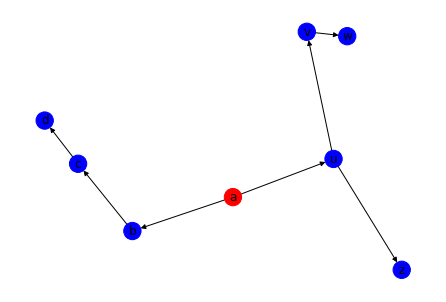

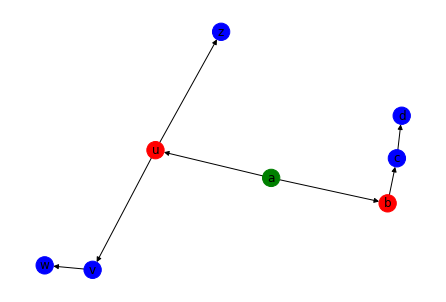

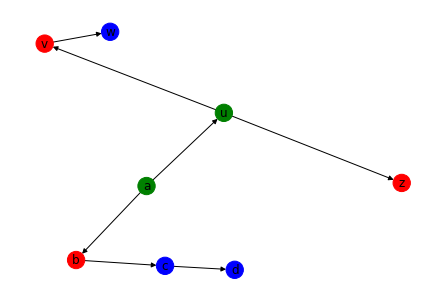

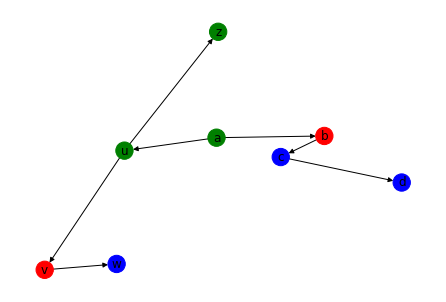

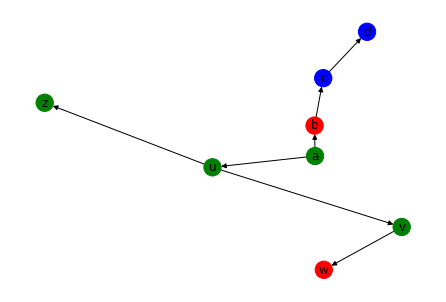

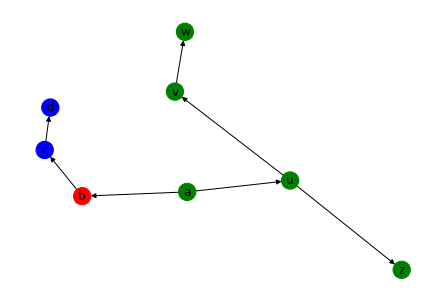

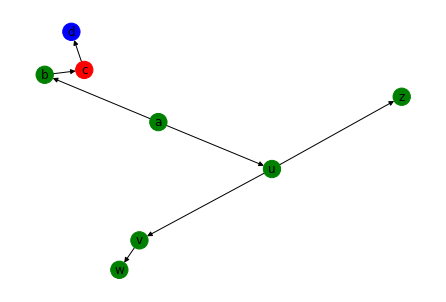

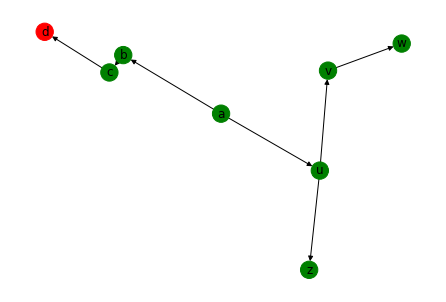

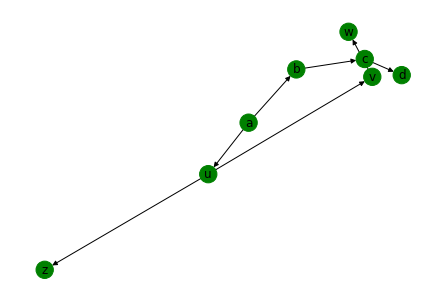

{'a', 'b', 'c', 'd', 'u', 'v', 'w', 'z'}

In [19]:
depth_first(gg, 'a')


We see how in depth-first search we explore completely one side of the successors of $a$, consisting of $u, v, w, z$, before exploring the other side $b, c, d$. 

### Efficient breadth-first search

Our original code for breadth-first search is not very efficient.  In particular, in the loop: 

        for w in g.successors(u) - vclosed:
            if w not in vopen:
                vopen.append(w)

the check `v not in vopen` can be quite expensive: `vopen` is now a list, and checking membership in a list takes time proportional to the length of the list, as on average half of it will need to be traversed. 

There are various ways of achieving a more efficient implementation.  One can, for instance, store the open nodes both as a list `vopen_list`, in order to keep track of their order, and as a set `vopen`, to facilitate the membership test.  Below is such an implementation. 

In [20]:
def efficient_breath_first(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    # vopen is a FIFO: first in, first out. Like a normal queue.
    # we add elements from the end, and pop them from the beginning.
    vopen_list = [v]
    vopen = {v}
    vclosed = set()
    color_draw(g, vopen, vclosed)
    while len(vopen) > 0:
        u = vopen_list.pop(0)
        vopen -= {u}
        vclosed.add(u)
        # Not:
        # new_successors = g.successors(u) - (vopen | vclosed)
        # new_successors = g.successors(u) - vopen - vclosed
        # {w for w in g.successors(u) if w not in vclosed | vopen)}
        new_successors = {w for w in g.successors(u) if not (w in vclosed) or (w in vopen)}
        vopen.update(new_successors)
        vopen_list.extend(new_successors)
        color_draw(g, vopen, vclosed)
    return vclosed


We also noted some versions of the check at line 18 that are potentially less efficient.  For instance, 

    new_successors = g.successors(u) - (vopen | vclosed)

would require the computation of the set `vopen | vclosed`, which is potentially large.  The efficiency of 

    new_successors = g.successors(u) - vopen - vclosed

depends on how the set difference operation is implemented in Python: specifically, when you have $A - B$, does Python: 

1. Iterate over $A$, returning all elements of $A$ that do not occur in $B$: 

        {x for x in A if x not in B}

2. Iterate over $B$, removing each element in $B$ from those of $A$: 

        R = set(A)
        for x in B:
            R.discard(x)
        return R

Obviously, 1. is more efficient if $|B| > |A|$, and 2. is more efficient when $|A| > |B|$.  So relying on set difference would put us at the mercy of the Python implementation.  Finally, 

    {w for w in g.successors(u) if w not in vclosed | vopen)}

is a disastrous choice, as it calls for computing `vclosed | vopen`, which as mentioned can be very large.  Our chosen solution

    new_successors = {w for w in g.successors(u) if not (w in vclosed) or (w in vopen)}

guarantees efficiency if `g.successors(u)` is smaller than `vclosed` and `vopen`, which is usually the case. 



## Reachability as a method

Let's now endow our graph with a method that yields the vertices reachable from any given starting vertex.

In [21]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        self.s = {u: set() for u in vertices or []}
        for u, v in (edges or []):
            self.add_edge((u, v))

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.s.keys())
        g.add_edges_from([(u, v) for u in self.s for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        if v not in self.s:
            self.s[v] = set()

    def add_edge(self, e):
        u, v = e
        self.add_vertex(u)
        self.add_vertex(v)
        self.s[u].add(v)

    @property
    def vertices(self):
        return set(self.s.keys())

    def successors(self, u):
        """Returns true iff one can get from vertex v to vertex u by following
        one edge."""
        return self.s[u]

    def __eq__(self, other):
        """We need to define graph equality."""
        if self.vertices != other.vertices:
            return False
        for v, d in self.s.items():
            if d != other.s[v]:
                return False
        return True

    def __repr__(self):
        r = "Graph:"
        for v in self.vertices:
            r += "\n %r : %r" % (v, self.s.get(v))
        return r

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from([(u, v) for u in self.vertices for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)
        # We must be careful not to overwrite the successor relation
        # in case v might already be present in the graph.
        self.s[v] = self.s.get(v, set())

    def add_edge(self, e):
        """Adds an edge e = (u, v) between two vertices u, v.  If the
        two vertices are not already in the graph, adds them."""
        u, v = e
        self.vertices.update({u, v})
        # Initializes the successor function if needed.
        self.s[u] = self.s.get(u, set()) | {v}
        self.s[v] = self.s.get(v, set())

    def successors(self, u):
        """Returns the set of successors of a vertex u"""
        return self.s[u]

    def reachable(self, v):
        """Returns the set of vertices reachable from an initial vertex v."""
        vopen = {v}
        vclosed = set()
        while len(vopen) > 0:
            u = vopen.pop()
            vclosed.add(u)
            vopen.update(self.s[u] - vclosed)
        return vclosed


### Testing the implementation

This seems to be a reasonable implementation.  Let us do some tests, to check that everything works as expected.  The nose tools are very handy for testing.
We have written a _check function that enables us to test whether the definition of a graph is self consistent.  Writing such consistency checks is very useful.  In development, we may call them often.  In production code, we may choose to call them at key points in the code, to prevent the propagation of errors to distant places in the code. 

In [22]:
import random


Let's build constructors for random graphs.

In [23]:
vertices = list('abcdefghilmnopqrstuvz')

def random_vertices():
    """Returns a set of random vertices."""
    return set(random.choices(vertices, k=12))

def random_edges(vs):
    """Returns a set of random edges, given a set of vertices."""
    vxv = [(u, v) for u in vs for v in vs]
    return set(random.choices(vxv, k=min(len(vxv), 50)))

def random_graph():
    vs = random_vertices()
    e = random_edges(vs)
    return Graph(vertices=vs, edges=e)


We can create random graphs.

In [24]:
for _ in range(100):
    g = Graph()
    vs = random_vertices()
    es = random_edges(vs)
    for e in es:
        g.add_edge(e)


Let's check that the graph we obtain does not depend on the order with which we add the vertices and edges.

In [25]:
for _ in range(100):
    vs = random_vertices()
    es = list(random_edges(vs))
    g1 = Graph(vertices=vs, edges=es)
    g2 = Graph(vertices=vs)
    g3 = Graph(vertices=vs)
    esp = es[:] # Creates a copy.
    random.shuffle(esp)
    for e in es:
        g2.add_edge(e)
    for e in esp:
        g3.add_edge(e)
    assert g1 == g2
    assert g1 == g3


**Excerise:** Implement graph difference.

**Exercise:** Implement graph union.

Write a `union` method for a graph so that, for $G_1 = (V_1, E_1)$ and $G_2 = (V_2, E_2)$, with $G_1$ represented by `g1` in code and $G_2$ represented by `g2`, 

    g1 | g2

returns the graph $G_{12} = (V_1 \cup V_2, E_1 \cup E_2)$ having as vertices the union of the vertices of $G_1$ and $G_2$, and as edges the union of the edges of $G_1$ and $G_2$.


## Is a graph a tree? 

A tree is a graph $(V, E)$ with two special properties: 

* Every vertex has at most one incoming edge.
* Either there are no vertices, or there is a vertex with no incoming edges, called the _root_, from which all other vertices are reachable. 

If the second property does not hold, incidentally, the graph is called a _forest._

Write an `is_tree` property that has value True if the graph is a tree, and has value False otherwise.

In [28]:
 #@title Implementation of tree test

def graph_is_tree(self):
    """Returns True iff the graph is a tree."""
    ### BEGIN SOLUTION
    raise NotImplementedError()
    ### END SOLUTION

Graph.is_tree = property(graph_is_tree)


In [29]:
 #@title Tests for `is_tree`

g = Graph(vertices=[1, 2, 3], edges=[(1, 2), (1, 3)])
assert_true(g.is_tree)
g = Graph(vertices=[1, 2, 3], edges=[(1, 2), (2, 3), (1, 3)])
assert_false(g.is_tree)
g = Graph(vertices=[1, 2, 3], edges=[(1, 3), (2, 3)])
assert_false(g.is_tree)


NameError: ignored

In [30]:
### More tests for `is_tree`

g = Graph()
assert_true(g.is_tree)


NameError: ignored

**Exercise:** Write a function `number_of_islands` that counts the number of islands of horizonally-or-vertically connected 1s in a matrix of 0, 1 elements. 

**Exercise:** Write a `has_loop` method that checks whether a graph has a loop.